In [ ]:
!pip install facenet_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 41.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 105.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 116.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 41.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124

In [ ]:


# Import required libraries
import zipfile
import os

# Define paths for the ZIP file and the extraction directory
zip_path = '/content/archive (2).zip'  # Update with your actual path
extracted_dir = '/content/extracted_images'  # Directory to store extracted images

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

print("Extraction complete.")


Extraction complete.


In [ ]:
import pandas as pd

# Load the DataFrame containing image paths and labels
path_df = pd.read_csv('/content/image_paths_labels.csv')  # Update with actual path

# Update image paths to include the extraction directory
path_df['image_path'] = extracted_dir + '/' + path_df['image_path'].str.replace('\\', '/')

# Verify updated paths
print(path_df.head())


                                          image_path   label
0  /content/extracted_images/student-images/face_...  face_0
1  /content/extracted_images/student-images/face_...  face_0
2  /content/extracted_images/student-images/face_...  face_0
3  /content/extracted_images/student-images/face_...  face_0
4  /content/extracted_images/student-images/face_...  face_0


In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

def show_image(image_path, title='Image Display'):
    img = Image.open(image_path)
    img = img.resize((128, 128))
    img_rgb = img.convert("RGB")
    plt.figure(figsize=(2, 2))
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.title(title)
    plt.show()


In [ ]:
import random

def gen_random(n, exclude):
    numbers = [x for x in range(54) if x != exclude]
    return random.sample(numbers, n)

def create_triplet_pairs(path_df):
    storage = []
    for i in range(54):  # Assuming 54 unique faces
        df = path_df[path_df['label'] == f'face_{i}']
        original = df['image_path'].iloc[-1]  # Use last as original

        for aug_img, neg_label in zip(df['image_path'].iloc[:-1], gen_random(16, i)):
            storage.append({
                'anchor': original,
                'positive': aug_img,
                'negative': path_df[path_df['label'] == f'face_{neg_label}']['image_path'].iloc[-1]
            })

    return pd.DataFrame(storage)

# Create the pairs DataFrame
pair_df = create_triplet_pairs(path_df)
print(pair_df.head())


                                              anchor  \
0  /content/extracted_images/student-images/face_...   
1  /content/extracted_images/student-images/face_...   
2  /content/extracted_images/student-images/face_...   
3  /content/extracted_images/student-images/face_...   
4  /content/extracted_images/student-images/face_...   

                                            positive  \
0  /content/extracted_images/student-images/face_...   
1  /content/extracted_images/student-images/face_...   
2  /content/extracted_images/student-images/face_...   
3  /content/extracted_images/student-images/face_...   
4  /content/extracted_images/student-images/face_...   

                                            negative  
0  /content/extracted_images/student-images/face_...  
1  /content/extracted_images/student-images/face_...  
2  /content/extracted_images/student-images/face_...  
3  /content/extracted_images/student-images/face_...  
4  /content/extracted_images/student-images/face_..

In [ ]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


In [ ]:
from torch.utils.data import Dataset, DataLoader
import torch

class TripletImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        try:
            anchor_path = self.dataframe.iloc[idx]['anchor']
            positive_path = self.dataframe.iloc[idx]['positive']
            negative_path = self.dataframe.iloc[idx]['negative']

            anchor = Image.open(anchor_path).convert('RGB')
            positive = Image.open(positive_path).convert('RGB')
            negative = Image.open(negative_path).convert('RGB')

            if self.transform:
                anchor = self.transform(anchor)
                positive = self.transform(positive)
                negative = self.transform(negative)

            return anchor, positive, negative
        except FileNotFoundError as e:
            print(f"File not found: {e}")
            return None

triplet_dataset = TripletImageDataset(dataframe=pair_df, transform=transform)
dataloader = DataLoader(triplet_dataset, batch_size=32, shuffle=True)


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import torch.nn as nn
from facenet_pytorch import InceptionResnetV1

class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.base_model = InceptionResnetV1(pretrained='vggface2').eval()
        for param in self.base_model.parameters():
            param.requires_grad = False

        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 512)
        self.embedding_layer = nn.Linear(512, 512)
        self.batch_norm = nn.BatchNorm1d(512)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.5)

    def forward(self, x):
        x = self.base_model(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.batch_norm(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.embedding_layer(x)
        return x

# Initialize the model
model = SiameseNetwork().to(device)


In [ ]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
triplet_loss = nn.TripletMarginLoss(margin=1.0, p=2)


In [ ]:
num_epochs = 10
loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch in dataloader:
        if batch is None:
            continue  # Skip batch if it contains None due to missing files

        anchor, positive, negative = batch
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)

        optimizer.zero_grad()

        anchor_out = model(anchor)
        positive_out = model(positive)
        negative_out = model(negative)

        loss = triplet_loss(anchor_out, positive_out, negative_out)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    average_loss = running_loss / len(dataloader)
    loss_history.append(average_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f}")


Epoch [1/10], Loss: 0.1149
Epoch [2/10], Loss: 0.0524
Epoch [3/10], Loss: 0.0219
Epoch [4/10], Loss: 0.0194
Epoch [5/10], Loss: 0.0194
Epoch [6/10], Loss: 0.0202
Epoch [7/10], Loss: 0.0129
Epoch [8/10], Loss: 0.0158
Epoch [9/10], Loss: 0.0149
Epoch [10/10], Loss: 0.0105


In [ ]:
torch.save(model.state_dict(), 'siamese_model.pth')

In [ ]:
import pickle

# Make sure the model is in evaluation mode
model.eval()

# Initialize the dictionary to store embeddings
embedding_dict = {}

# Generate embeddings for each unique image in path_df
for idx, row in path_df.iterrows():
    img_path = row['image_path']
    label = row['label']

    # Load and transform the image
    image = Image.open(img_path).convert('RGB')
    image_tensor = transform(image).unsqueeze(0).to(device)

    # Get embedding from the model
    with torch.no_grad():  # Disable gradient calculation for inference
        embedding = model(image_tensor).squeeze().cpu().tolist()  # Convert to list for easy storage

    # Store the embedding in the dictionary
    embedding_dict[label] = embedding

# Optionally, save the embedding dictionary to a file for later use
with open('embedding_dict.pkl', 'wb') as f:
    pickle.dump(embedding_dict, f)

print("Embeddings generated and saved.")


Embeddings generated and saved.


In [ ]:
!pip install mtcnn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 32.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 60.3 MB/s eta 0:00:00


In [ ]:
import cv2

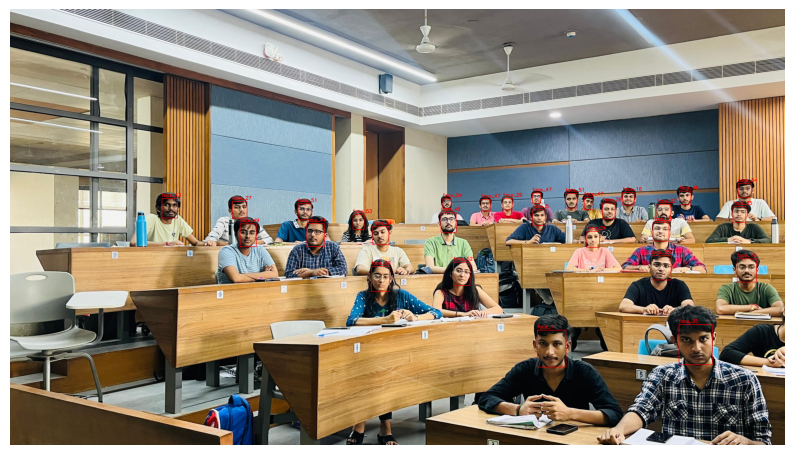

In [ ]:
import torch.nn.functional as F
import cv2
from PIL import Image
from mtcnn import MTCNN
import matplotlib.pyplot as plt
import numpy as np

# Initialize the MTCNN detector
detector = MTCNN()

# Function to find the most similar face
def find_most_similar(face_image, threshold=0.3):
    # Set the model to evaluation mode
    model.eval()

    # Transform the input face image (PIL Image) and convert it to a tensor
    image_tensor = transform(face_image).unsqueeze(0).to(device)  # Add batch dimension
    embedding = model(image_tensor).squeeze()  # Get embedding and remove batch dimension

    # Initialize similarity tracking variables
    highest_similarity = -1
    most_similar_face = None

    # Compare the embedding with stored embeddings
    for label, emb in embedding_dict.items():
        emb_tensor = torch.tensor(emb).to(device)
        similarity = F.cosine_similarity(embedding, emb_tensor, dim=0)

        # Update highest similarity and corresponding label
        if similarity > highest_similarity:
            highest_similarity = similarity
            most_similar_face = label

    # Return the most similar face if above threshold; otherwise "Unknown"
    return most_similar_face if highest_similarity > threshold else "Unknown"

# Function to detect faces and recognize each one in an image
def detect_and_recognize_faces(image_path, threshold=0.3):
    # Load the image using OpenCV
    image = cv2.imread(image_path)
    if image is None:
        print("Error: Unable to open image file.")
        return
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect faces
    faces = detector.detect_faces(rgb_image)

    # Process each detected face
    for face in faces:
        x, y, width, height = face['box']

        # Extract face from image for recognition
        face_image = rgb_image[y:y+height, x:x+width]
        face_pil = Image.fromarray(face_image)  # Convert to PIL Image

        # Find the most similar face
        most_similar_face = find_most_similar(face_pil, threshold)

        # Draw red bounding box and label on the original image
        label = most_similar_face if most_similar_face else "Unknown"
        cv2.rectangle(image, (x, y), (x + width, y + height), (0, 0, 255), 2)
        cv2.putText(image, label, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 255), 2)

    # Display the image with bounding boxes and labels
    rgb_image_with_boxes = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10, 10))
    plt.imshow(rgb_image_with_boxes)
    plt.axis("off")
    plt.show()

# Test the function
test_image = "/content/WhatsApp Image 2024-11-13 at 00.19.26_acd81f31.jpg"  # Update with actual path
detect_and_recognize_faces(test_image)


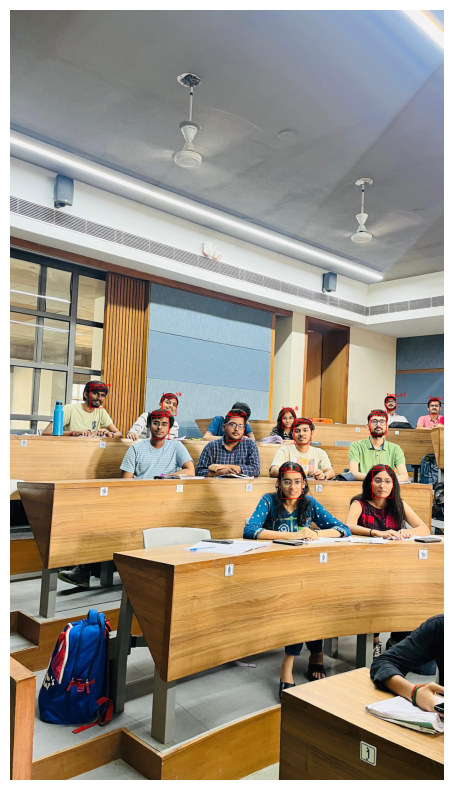

In [ ]:

test_image = "/content/targetimage2.jpg"  # Update with actual path
detected_faces = detect_and_recognize_faces(test_image)

